In [1]:
from collections import Counter
from random import random
from nltk import word_tokenize,sent_tokenize
from torch import nn
from torch.autograd import Variable
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
import re
import numpy as np
import torch
import torch.nn.functional as F
import os
# from utils import *
from torch.utils.data import DataLoader, Dataset, IterableDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
# from simple_optimizer import Optimizer
import sys
# from models import *
import argparse
from transformers import BertModel, BertConfig
# from run import *
import matplotlib.pyplot as plt
# import allennlp.nn
from build_gt_tree import *
from transformers import BertTokenizer, BertConfig
from evaluation import *
import matplotlib.pyplot as plt
# from torchsummary import summary

# RSTDT

In [ ]:
all_data = []
# dir_path = '/ubc/cs/research/nlp/corpora/RST-DT/rst_discourse_treebank/data/RSTtrees-WSJ-main-1.0/TRAINING/'
dir_path = '/scratch/wenxiao/rst-dt_revised/TRAINING/'
files = [fname.split('.')[0] for fname in os.listdir(dir_path) if fname.endswith('.edus')]
for file in files:
    edu_file = dir_path+'/'+file+'.out.edus'
    sent_file = dir_path+'/'+file+'.out'
    if not os.path.exists(edu_file):
        edu_file = dir_path+'/'+file+'.edus'
        sent_file = dir_path+'/'+file
    with open(edu_file,'r') as of:
        edu_text = of.readlines()
    with open(sent_file,'r') as of:
        sent_text = of.readlines()
    
    all_data.append(build_dataset(edu_text,sent_text,file.split('.')[0]))
torch.save(all_data,'./train/train.pt')

In [ ]:
def build_dataset(edu_text,sent_text,fid):
#     all_sents = ' '.join([line.strip() for line in text])
    print(fid)
    sentences = [s.strip().lower() for s in sent_text if s.strip()!='']
    edus=[edu.strip().lower() for edu in edu_text]
    edu_sent_mapping=map_edu_sent(edus,sentences)
    data={}
    data['disco_txt'] = [word_tokenize(edu) for edu in edus]
    data['sent_txt'] = [word_tokenize(s) for s in sentences]
    data['tgt_list_str']=['Place Holder']
    data['tgt_tok_list_list_str'] = [['Place','Holder']]
    data['d_labels'] = [[1]+[0]*(len(data['disco_txt'])-1)]
    data['labels'] = [[1]+[0]*(len(data['sent_txt'])-1)]
    data['disco_dep']=[]
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='/scratch/wenxiao/pretrained_bert/',do_lower_case=True)
    src,lengths=get_bert_idxs(tokenizer,edus,edu_sent_mapping)
    data['d_span']=get_dspan(lengths, src)
#     print(data['d_span'])
    data['doc_id']=fid
    data['src']=src

    return data

In [ ]:
def get_bert_idxs(tokenizer,edus,edu_sent_mapping):

    sep_vid = tokenizer.vocab['[SEP]']
    cls_vid = tokenizer.vocab['[CLS]']
    pad_vid = tokenizer.vocab['[PAD]']
    sent_to_edu={}
    for edu,sent in enumerate(edu_sent_mapping):
        sent_to_edu[sent]=sent_to_edu.get(sent,[])+[edu]
    src_subtokens = []
    lengths = []
    for sent in sent_to_edu.keys():
        sent_subtokens = ['[CLS]']
        for edu_idx in sent_to_edu[sent]:
            tokens = tokenizer.tokenize(edus[edu_idx])
            sent_subtokens.extend(tokens)
            lengths.append(len(tokens))
        sent_subtokens.append('[SEP]')
        src_subtokens.append(sent_subtokens)
#     src_subtokens = [['[CLS]']+tokenizer.tokenize(' '.join(sent))+['[SEP]'] for sent in src]
#     print(src_subtokens)
#     tokenizer.tokenize(' '.join(sent)) for sent in src]
#     src_subtokens = [['[CLS]']+sent+['[SEP]'] for sent in src]
    src_subtoken_idxs = [tokenizer.convert_tokens_to_ids(sent) for sent in src_subtokens]
    segs=[]
    cur_seg=0
    for sent in src_subtoken_idxs:
        segs.extend([cur_seg]*len(sent))
        cur_seg=1-cur_seg
        cur_clss+=(len(sent)-1)
    src_subtoken_idxs = [token for sent in src_subtoken_idxs for token in sent]
    return src_subtoken_idxs,lengths,segs

def get_dspan(edu_lengths, src):
    d_span=[]
    start_idx =1
    for edu_l in edu_lengths:
        if src[start_idx]==102:
            start_idx+=2
        d_span.append((start_idx,start_idx+edu_l))
        start_idx = start_idx+edu_l
    return d_span  

def map_edu_sent(edu_text,sent_text):
    edu_sent_mapping = []
    cur_sent = ''
    cur_sent_idx=0
    for edu in edu_text:
        cur_sent+=edu
        edu_sent_mapping.append(cur_sent_idx)
        if cur_sent==sent_text[cur_sent_idx]:
            cur_sent=''
            cur_sent_idx+=1
        else:
            cur_sent+=' '

    if len(sent_text)-1!=edu_sent_mapping[-1]:
        print(cur_sent)
        print(sent_text[cur_sent_idx])
    return edu_sent_mapping
            

In [ ]:
###### BUILD DATASET FROM VERTIBI EM PAPER
def build_dataset_with_boundaries(edu_text,sentence_boundary,paragraph_boundary,fid):
#     all_sents = ' '.join([line.strip() for line in text])
    print(fid)
    edus=[edu.strip().lower() for edu in edu_text]
    assert len(edus)==sentence_boundary[-1][-1]+1
    assert len(sentence_boundary)==paragraph_boundary[-1][-1]+1
    edu_sent_mapping=[]
    for i, (s_start,s_end) in enumerate(sentence_boundary):
        edu_sent_mapping+=[i]*(s_end-s_start+1)
    data={}
    data['disco_txt'] = [word_tokenize(edu) for edu in edus]
    data['sent_txt'] = [[token for edu in data['disco_txt'][s_start:s_end+1] for token in edu] for (s_start,s_end) in sentence_boundary]
    data['tgt_list_str']=['Place Holder']
    data['tgt_tok_list_list_str'] = [['Place','Holder']]
    data['d_labels'] = [[1]+[0]*(len(data['disco_txt'])-1)]
    data['labels'] = [[1]+[0]*(len(data['sent_txt'])-1)]
    data['disco_dep']=[]
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='/scratch/wenxiao/pretrained_bert/',do_lower_case=True)
    src,lengths,segs=get_bert_idxs(tokenizer,edus,edu_sent_mapping)
    data['d_span']=get_dspan(lengths, src)
    data['segs']=segs
#     print(data['d_span'])
    data['sentence_boundary']= sentence_boundary
    data['paragraph_boundary'] = paragraph_boundary
    data['doc_id']=fid
    data['src']=src
    

    return data

In [ ]:
all_data = []
# dir_path = '/ubc/cs/research/nlp/corpora/RST-DT/rst_discourse_treebank/data/RSTtrees-WSJ-main-1.0/TRAINING/'
dir_path = '/ubc/cs/research/nlp/wenxiao/discourse_Constituency_EM/data/rstdt/wsj/test/'
files = [fname.split('.')[0] for fname in os.listdir(dir_path) if fname.endswith('.edus.tokens')]
for file in files:
    edu_file = dir_path+'/'+file+'.edus.tokens'
    with open(edu_file,'r') as of:
        edu_text = of.readlines()
        
    s_bndry_file = dir_path+'/'+file+'.sbnds'
    with open(s_bndry_file,'r') as of:
        lines = of.readlines()
        s_bndry=[]
        for l in lines:
            s=l.split()
            s_bndry.append((int(s[0]),int(s[1])))
            
    p_bndry_file = dir_path+'/'+file+'.pbnds'
    with open(p_bndry_file,'r') as of:
        lines = of.readlines()
        p_bndry=[]
        for l in lines:
            p=l.split()
            p_bndry.append((int(p[0]),int(p[1])))
    
    all_data.append(build_dataset_with_boundaries(edu_text,s_bndry,p_bndry,file))
dir_path = '/ubc/cs/research/nlp/wenxiao/discourse_Constituency_EM/data/rstdt/wsj/train/'
files = [fname.split('.')[0] for fname in os.listdir(dir_path) if fname.endswith('.edus.tokens')]
for file in files:
    edu_file = dir_path+'/'+file+'.edus.tokens'
    with open(edu_file,'r') as of:
        edu_text = of.readlines()
        
    s_bndry_file = dir_path+'/'+file+'.sbnds'
    with open(s_bndry_file,'r') as of:
        lines = of.readlines()
        s_bndry=[]
        for l in lines:
            s=l.split()
            s_bndry.append((int(s[0]),int(s[1])))
            
    p_bndry_file = dir_path+'/'+file+'.pbnds'
    with open(p_bndry_file,'r') as of:
        lines = of.readlines()
        p_bndry=[]
        for l in lines:
            p=l.split()
            p_bndry.append((int(p[0]),int(p[1])))
    
    all_data.append(build_dataset_with_boundaries(edu_text,s_bndry,p_bndry,file))
torch.save(all_data,'./em_dataset/all/all.pt')

# Instruction

In [3]:
def build_dataset(dis_text,fid):
#     all_sents = ' '.join([line.strip() for line in text])
    edu_sent_mapping,edus,sentences,sentence_boundary,paragraph_boundary = map_edu_sent_para(dis_text)
    data={}
    data['disco_txt'] = [word_tokenize(edu) for edu in edus]
    data['sent_txt'] = [word_tokenize(s) for s in sentences]
    data['tgt_list_str']=['Place Holder']
    data['tgt_tok_list_list_str'] = [['Place','Holder']]
    data['d_labels'] = [[1]+[0]*(len(data['disco_txt'])-1)]
    data['labels'] = [[1]+[0]*(len(data['sent_txt'])-1)]
    data['disco_dep']=[]
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='/scratch/wenxiao/pretrained_bert/',do_lower_case=True)
    src,lengths=get_bert_idxs(tokenizer,edus,edu_sent_mapping)
    data['d_span']=get_dspan(lengths, src)
#     print(data['d_span'])
    data['doc_id']=fid
    data['src']=src
    data['sentence_boundary']= sentence_boundary
    data['paragraph_boundary'] = paragraph_boundary

    return data

In [4]:
def get_bert_idxs(tokenizer,edus,edu_sent_mapping):

    sep_vid = tokenizer.vocab['[SEP]']
    cls_vid = tokenizer.vocab['[CLS]']
    pad_vid = tokenizer.vocab['[PAD]']
    sent_to_edu={}
    for edu,sent in enumerate(edu_sent_mapping):
        sent_to_edu[sent]=sent_to_edu.get(sent,[])+[edu]
    src_subtokens = []
    lengths = []
    for sent in sent_to_edu.keys():
        sent_subtokens = ['[CLS]']
        for edu_idx in sent_to_edu[sent]:
            tokens = tokenizer.tokenize(edus[edu_idx])
            sent_subtokens.extend(tokens)
            lengths.append(len(tokens))
        sent_subtokens.append('[SEP]')
        src_subtokens.append(sent_subtokens)
#     src_subtokens = [['[CLS]']+tokenizer.tokenize(' '.join(sent))+['[SEP]'] for sent in src]
#     print(src_subtokens)
#     tokenizer.tokenize(' '.join(sent)) for sent in src]
#     src_subtokens = [['[CLS]']+sent+['[SEP]'] for sent in src]
    src_subtoken_idxs = [tokenizer.convert_tokens_to_ids(sent) for sent in src_subtokens]
    segs=[]
    cur_seg=0
    for sent in src_subtoken_idxs:
        segs.extend([cur_seg]*len(sent))
        cur_seg=1-cur_seg
#         cur_clss+=(len(sent)-1)
    src_subtoken_idxs = [token for sent in src_subtoken_idxs for token in sent]
    return src_subtoken_idxs,lengths

def get_dspan(edu_lengths, src):
    d_span=[]
    start_idx =1
    for edu_l in edu_lengths:
        if src[start_idx]==102:
            start_idx+=2
        d_span.append((start_idx,start_idx+edu_l))
        start_idx = start_idx+edu_l
    return d_span  

def map_edu_sent_para(dis_text):
    edu_sent_mapping = []
    edu_text=re.findall(r'\(text (.*?)\) \)', dis_text)
    disco_txt=[]
    sent_txt=[]
    sentence_boundary=[]
    cur_sent_start=0
    cur_sent_idx=0
    cur_sent=''
    for i_edu,edu in enumerate(edu_text):
        edu_sent_mapping.append(cur_sent_idx)
        revised_edu = edu.replace('<EDU>','').replace('</EDU>','').replace('<s>','').replace('</s>','')
        disco_txt.append(revised_edu)
        cur_sent=cur_sent + ' ' +revised_edu
        if '</s>' in edu:
            sent_txt.append(cur_sent)
            sentence_boundary.append((cur_sent_start,i_edu))
            cur_sent_idx+=1
            cur_sent=''
            cur_sent_start=i_edu+1
    all_wrong_leaf = re.findall(r'Root \(leaf (.*?)\)', dis_text)
    if len(all_wrong_leaf)!=0:
        for l in all_wrong_leaf:
#             print(l)
            dis_text = dis_text.replace('Root (leaf %s)'%(l),'Root (span %s %s)'%(l,l))
#             print(dis_text)
    all_root = re.findall(r'Root \(span (.*?)\)', dis_text)
    cur_para_start=0
    paragraph_boundary = []
    for span in all_root:
        span = span.split()
        first_id = int(span[0])-1
        last_id= int(span[1])-1
        if sentence_boundary[cur_para_start][0]!=first_id:
            raise 'error on para boundary!!'
        end = cur_para_start
        while sentence_boundary[end][1]!=last_id:
            end+=1
            if end>=len(sentence_boundary):
                print(sentence_boundary)
                print(disco_txt)
                print(sent_txt)
                raise 'error on para boundary!!'
        paragraph_boundary.append((cur_para_start,end))
        cur_para_start = end+1
    if cur_para_start!=len(sentence_boundary):
        raise 'error again.....'
    return edu_sent_mapping,disco_txt,sent_txt,sentence_boundary,paragraph_boundary

    

In [5]:
all_data = []
dir_path = '/scratch/wenxiao/instruction_discourse_annotation/'
# files = [fname for fname in os.listdir(dir_path) if fname.endswith('.dis')]
files = ['sunset2-3-ceramic.21.out.dis',
'sunset1-paint.22.out.dis',
'sunset1-prep.2.out.dis',
'sunset2-3-ceramic.36.out.dis',
'sunset1-fabric.19.out.dis',
'sunset2-3-ceramic.15.out.dis',
'sunset2-5-parquet.11.out.dis',
'sunset2-4-resil.6.out.dis',
'sunset1-paint.5.out.dis',
'sunset2-3-ceramic.6.out.dis',
'sunset1-panel.8.out.dis',
'sunset2-3-ceramic.24.out.dis',
'sunset2-5-parquet.10.out.dis',
'sunset2-4-resil.3.out.dis',
'sunset1-paint.11.out.dis',
'sunset2-3-ceramic.26.out.dis',
'sunset1-panel.4.out.dis',
'sunset1-fabric.4.out.dis']
for file in files:
    with open(dir_path+file,'r') as of:
        dis_text = of.read()
    fid = '%s_%s'%(file.split('.')[0],file.split('.')[1])
    print(fid)
    all_data.append(build_dataset(dis_text,fid))
torch.save(all_data,'./instruction_dataset/test.pt')

sunset2-3-ceramic_21
sunset1-paint_22
sunset1-prep_2
sunset2-3-ceramic_36
sunset1-fabric_19
sunset2-3-ceramic_15
sunset2-5-parquet_11
sunset2-4-resil_6
sunset1-paint_5
sunset2-3-ceramic_6
sunset1-panel_8
sunset2-3-ceramic_24
sunset2-5-parquet_10
sunset2-4-resil_3
sunset1-paint_11
sunset2-3-ceramic_26
sunset1-panel_4
sunset1-fabric_4


# GUM dataset

In [4]:
def build_dataset(edus,sentences,fid):
    edus = [edu.strip('\n') for edu in edus]
    sentences = [sent.strip('\n') for sent in sentences]
#     all_sents = ' '.join([line.strip() for line in text])
    edu_sent_mapping,sentence_boundary,paragraph_boundary = map_edu_sent_para(edus,sentences)
    data={}
    data['disco_txt'] = [word_tokenize(edu) for edu in edus]
    data['sent_txt'] = [word_tokenize(s) for s in sentences]
    data['tgt_list_str']=['Place Holder']
    data['tgt_tok_list_list_str'] = [['Place','Holder']]
    data['d_labels'] = [[1]+[0]*(len(data['disco_txt'])-1)]
    data['labels'] = [[1]+[0]*(len(data['sent_txt'])-1)]
    data['disco_dep']=[]
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='/scratch/wenxiao/pretrained_bert/',do_lower_case=True)
    src,lengths=get_bert_idxs(tokenizer,edus,edu_sent_mapping)
    data['d_span']=get_dspan(lengths, src)
#     print(data['d_span'])
    data['doc_id']=fid
    data['src']=src
    data['sentence_boundary']= sentence_boundary
    data['paragraph_boundary'] = paragraph_boundary

    return data

In [8]:
def get_bert_idxs(tokenizer,edus,edu_sent_mapping):

    sep_vid = tokenizer.vocab['[SEP]']
    cls_vid = tokenizer.vocab['[CLS]']
    pad_vid = tokenizer.vocab['[PAD]']
    sent_to_edu={}
    for edu,sent in enumerate(edu_sent_mapping):
        sent_to_edu[sent]=sent_to_edu.get(sent,[])+[edu]
    src_subtokens = []
    lengths = []
    for sent in sent_to_edu.keys():
        sent_subtokens = ['[CLS]']
        for edu_idx in sent_to_edu[sent]:
            tokens = tokenizer.tokenize(edus[edu_idx])
            sent_subtokens.extend(tokens)
            lengths.append(len(tokens))
        sent_subtokens.append('[SEP]')
        src_subtokens.append(sent_subtokens)
#     src_subtokens = [['[CLS]']+tokenizer.tokenize(' '.join(sent))+['[SEP]'] for sent in src]
#     print(src_subtokens)
#     tokenizer.tokenize(' '.join(sent)) for sent in src]
#     src_subtokens = [['[CLS]']+sent+['[SEP]'] for sent in src]
    src_subtoken_idxs = [tokenizer.convert_tokens_to_ids(sent) for sent in src_subtokens]
    segs=[]
    cur_seg=0
    for sent in src_subtoken_idxs:
        segs.extend([cur_seg]*len(sent))
        cur_seg=1-cur_seg
#         cur_clss+=(len(sent)-1)
    src_subtoken_idxs = [token for sent in src_subtoken_idxs for token in sent]
    return src_subtoken_idxs,lengths

def get_dspan(edu_lengths, src):
    d_span=[]
    start_idx =1
    for edu_l in edu_lengths:
        if src[start_idx]==102:
            start_idx+=2
        d_span.append((start_idx,start_idx+edu_l))
        start_idx = start_idx+edu_l
    return d_span  

def map_edu_sent_para(edu_text,sent_text):
    edu_sent_mapping = []
    cur_sent = ''
    cur_sent_idx=0
    cur_sent_start_idx=0
    sentence_boundary=[]
    for i_edu,edu in enumerate(edu_text):
        cur_sent+=edu
        edu_sent_mapping.append(cur_sent_idx)
        if cur_sent==sent_text[cur_sent_idx]:
            sentence_boundary.append((cur_sent_start_idx,i_edu))
            cur_sent=''
            cur_sent_idx+=1
            cur_sent_start_idx=i_edu+1
        else:
            cur_sent+=' '

    if len(sent_text)-1!=edu_sent_mapping[-1]:
        print(cur_sent)
        print(sent_text[cur_sent_idx])
        raise 'errorrrrr'
    paragraph_boundary=[(0,len(sent_text)-1)]
    
    return edu_sent_mapping,sentence_boundary,paragraph_boundary
        
    edu_sent_mapping = []
    edu_text=re.findall(r'\(text _\!(.*?)\)_\! \)', dis_text)
    disco_txt=[]
    sent_txt=[]
    sentence_boundary=[]
    cur_sent_start=0
    cur_sent_idx=0
    cur_sent=''
    for i_edu,edu in enumerate(edu_text):
        edu_sent_mapping.append(cur_sent_idx)
        revised_edu = edu.replace('_!','').replace('<s>','').replace('</s>','')
        disco_txt.append(revised_edu)
        cur_sent=cur_sent + ' ' +revised_edu
        if '</s>' in edu:
            sent_txt.append(cur_sent)
            sentence_boundary.append((cur_sent_start,i_edu))
            cur_sent_idx+=1
            cur_sent=''
            cur_sent_start=i_edu+1
    all_wrong_leaf = re.findall(r'Root \(leaf (.*?)\)', dis_text)
    if len(all_wrong_leaf)!=0:
        for l in all_wrong_leaf:
#             print(l)
            dis_text = dis_text.replace('Root (leaf %s)'%(l),'Root (span %s %s)'%(l,l))
#             print(dis_text)
    all_root = re.findall(r'Root \(span (.*?)\)', dis_text)
    cur_para_start=0
    paragraph_boundary = []
    for span in all_root:
        span = span.split()
        first_id = int(span[0])-1
        last_id= int(span[1])-1
        if sentence_boundary[cur_para_start][0]!=first_id:
            raise 'error on para boundary!!'
        end = cur_para_start
        while sentence_boundary[end][1]!=last_id:
            end+=1
            if end>=len(sentence_boundary):
                print(sentence_boundary)
                print(disco_txt)
                print(sent_txt)
                raise 'error on para boundary!!'
        paragraph_boundary.append((cur_para_start,end))
        cur_para_start = end+1
    if cur_para_start!=len(sentence_boundary):
        raise 'error again.....'
    return edu_sent_mapping,disco_txt,sent_txt,sentence_boundary,paragraph_boundary

def revise_sentence_file(sent_text):
    sent_text=sent_text.replace('-LRB-','(')
    sent_text=sent_text.replace('-RRB-',')')
    sent_text=sent_text.replace('&amp;','&')
    return sent_text.split('\n')

def revise_edu_file(edu_text):
    edu_text=edu_text.replace('&amp;','&')
    edu_text=edu_text.replace('&lt;','<')
    return edu_text.split('\n')

In [ ]:
all_data = []
dir_path = '/scratch/wenxiao/GUM_binary/'
files = [fname for fname in os.listdir(dir_path) if fname.endswith('.out')]
for file in files:
    with open(dir_path+file,'r') as of:
        sent_txt = of.read()
    with open(dir_path+file+'.edus','r') as of:
        edu_txt = of.read()
    fid = file.split('.')[0]
    if fid=='GUM_voyage_fortlee':
        continue
    print(fid)
    sent_txt=revise_sentence_file(sent_txt)
    edu_txt=revise_edu_file(edu_txt)
    all_data.append(build_dataset(edu_txt,sent_txt,fid))
torch.save(all_data,'./GUM_binary/all.pt')

# Build ground-truth trees

In [31]:
def const_to_dep_tree_li14(node):
    const_leaves = get_leaf_nodes(node)
    dep_tree={}
    for leaf in const_leaves:
        print(leaf.start_idx)
        print(leaf.end_idx)
        p = find_my_top_node(leaf)
        print(p)
        if p.nuclearity=='Root':
            root = leaf.start_idx
        else:
            
            head = find_head_edu(p.parent)

            if head not in dep_tree:
                dep_tree[head]=[]
            dep_tree[head].append(leaf.start_idx)
#     print(dep_tree)
    return dep_tree,root

def find_my_top_node(e):
    C=e
    p = C.parent
    nucleus_child = [p.children[i] for i in range(len(p.children)) if p.children[i].nuclearity=='Nucleus']
    print(nucleus_child)
    while nucleus_child[0]==C and not p.nuclearity=='Root':
        C = p
        p = C.parent
        # print(p.idx)
        nucleus_child = [p.children[i] for i in range(len(p.children)) if p.children[i].nuclearity=='Nucleus']
    if p.nuclearity=='Root'and nucleus_child[0]==C:
        C=p
    return C

In [35]:
def construct_preorder(node_list,start,end,num_nonbinary=0):
    if start>end:
        return

    node = node_list[start]
    
    node_index_tupel = node[0]
    node_index_str = str(node[0])
    
    node_nuclearity = node[1]
    tmp_node = Node(idx = node_index_str, nuclearity = node_nuclearity,start=node_index_tupel[0],end=node_index_tupel[1])
    if start==end:
        return tmp_node,num_nonbinary
    i=start+1
    splits = []
    splits.append(i)
    while i<=end:
        if node_list[i][0][0]>node_list[splits[-1]][0][1]:
            splits.append(i)
            if node_index_tupel[1]==node_list[i][0][1]:
                break
        i+=1
    end_idx = node_index_tupel[1]
    splits.append(end)   
#     print(splits)
    right,num_nonbinary=construct_preorder(node_list,splits[-2],splits[-1],num_nonbinary)
    if len(splits)>3:
        while len(splits)>3:
            print('rb')
            num_nonbinary +=1
#             node_index_tupel = [node_list[splits[-3]][0][0],node_list[splits[-1]][0][1]]
            node_index_tupel = [node_list[splits[-3]][0][0],end_idx]
            node_index_str = str(node_index_tupel)
            if 'Nucleus' in [node_list[splits[-3]][1],node_list[splits[-2]][1]]:
                node_nuclearity = 'Nucleus'
            else:
                node_nuclearity = 'Satellite'
            # print(node_index_tupel)
            tmp_tmp_node = Node(idx = node_index_str, nuclearity = node_nuclearity,start=node_index_tupel[0],end=node_index_tupel[1])
            
            left,num_nonbinary = construct_preorder(node_list,splits[-3],splits[-2]-1,num_nonbinary)
            if left!=None:
                tmp_tmp_node.add_child(left,branch = 0)
            if right!=None:
                tmp_tmp_node.add_child(right,branch = 1)
            right = tmp_tmp_node
            del splits[-1]            
    left,num_nonbinary = construct_preorder(node_list,splits[-3],splits[-2]-1,num_nonbinary)
    if left!=None:
        tmp_node.add_child(left,branch = 0)
    if right!=None:
        tmp_node.add_child(right,branch = 1)
    return tmp_node,num_nonbinary

In [ ]:
tree_dir_list=['/scratch/wenxiao/rst-dt_revised/ALL/', \
                '/scratch/wenxiao/instruction_discourse_annotation/',\
                '/scratch/wenxiao/GUM_binary/']

# tree_dir_list=['/scratch/wenxiao/rst-dt_revised/ALL/']

dataset_list=['rstdt-full','instructional','GUM']
# dataset_list=['rstdt-full']
for i_data in range(len(tree_dir_list[:1])):
    savedtrees = torch.load('/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset_list[i_data]))
    dir_path = tree_dir_list[i_data]
    gt_tree_dict = {}
    files = [f for f in os.listdir(dir_path) if f.endswith('.dis')]
    num_data = len(files)
    num_edus_total = 0
    num_sentences_total = 0
    length_doc_total = 0
    for f in files:
        if f=='GUM_voyage_fortlee.out.dis':
            gt_tree_dict['GUM_voyage_fortlee']=[]
            continue
        file = dir_path+f
        with open(file,'r') as of:
            text = of.readlines()
        text=revise_instruction(file)
        list_nodes=convert_gt(text)
        root,num_nonbinary=construct_preorder(list_nodes,0,len(list_nodes)-1)
        const_tree_gt=return_tree_postorder(root)
        dep_tree_gt,dep_root=const_to_dep_tree_li14(root)
        
        if i_data ==1:
            fid = '%s_%s'%(f.split('.')[0],f.split('.')[1])
        else:
            if f == "file1.dis":
                fid= "wsj_0764"
            elif f == "file2.dis":
                fid =  "wsj_0430"
            elif f == "file3.dis":
                fid =  "wsj_0766"
            elif f == "file4.dis":
                fid =  "wsj_0778"
            elif f == "file5.dis":
                fid =  "wsj_2172"
            else:
                fid =f.split('.')[0]
        gt_tree_dict[fid]={'const_tree':const_tree_gt,'dep_tree':dep_tree_gt,'dep_root':dep_root}
        print(dep_tree_gt)
#     save_path='/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset_list[i_data])
#     torch.save(gt_tree_dict,save_path)

# Result Analysis 

In [45]:
def evaluate_dep_tree_list(dep_tree_gt_list,dep_tree_cand_list):
	correct_all=0
	total_all=0
	total_macro=0
	for i in range(len(dep_tree_gt_list)):
		correct,total=unlabeled_attachment_score(dep_tree_gt_list[i],dep_tree_cand_list[i])
		correct_all+=correct
		total_all+=total
		total_macro+=(correct/total)
	micro_f1 = correct_all/total_all
	macro_f1 = total_macro/len(dep_tree_gt_list)
# 	print('correct num: ',correct_all)
# 	print('total_num: ',total_all)
# 	print('micro f1: ',micro_f1)
# 	print('macro f1: ', macro_f1)
	return micro_f1,macro_f1


correct num:  689
total_num:  21404
micro f1:  3.219024481405345
macro f1:  6.1604377101101875
correct num:  1545
total_num:  21404
micro f1:  7.218276957578023
macro f1:  13.202230225019282
correct num:  1052
total_num:  21404
micro f1:  4.914969164642123
macro f1:  8.108697713090239
correct num:  820
total_num:  21404
micro f1:  3.831059615025229
macro f1:  9.57917793286025
correct num:  539
total_num:  21404
micro f1:  2.5182208932909735
macro f1:  6.183961831763682
correct num:  1065
total_num:  21404
micro f1:  4.975705475612035
macro f1:  12.216071830595096
correct num:  1337
total_num:  21404
micro f1:  6.246495982059428
macro f1:  11.279922862254251
correct num:  705
total_num:  21404
micro f1:  3.2937768641375444
macro f1:  5.601182306842524
correct num:  1275
total_num:  21404
micro f1:  5.956830498972155
macro f1:  10.20923773185731
correct num:  6102
total_num:  21404
micro f1:  28.508689964492618
macro f1:  36.256614625319976
correct num:  3107
total_num:  21404
micro f1: 

max: 35.390581, min: 12.852738, avg:19.182065
correct num:  201
total_num:  5578
micro f1:  3.60344209394048
macro f1:  5.058347831384409
correct num:  419
total_num:  5578
micro f1:  7.511652922194336
macro f1:  12.785652912441863
correct num:  221
total_num:  5578
micro f1:  3.961993546073862
macro f1:  6.929914248639002
correct num:  317
total_num:  5578
micro f1:  5.683040516314091
macro f1:  13.265576536355567
correct num:  156
total_num:  5578
micro f1:  2.7967013266403726
macro f1:  5.073238006984666
correct num:  391
total_num:  5578
micro f1:  7.0096808892076
macro f1:  15.519291087216272
correct num:  369
total_num:  5578
micro f1:  6.615274291860882
macro f1:  11.751372713055506
correct num:  250
total_num:  5578
micro f1:  4.481893151667264
macro f1:  7.632351157843428
correct num:  231
total_num:  5578
micro f1:  4.141269272140552
macro f1:  6.701002612452371
correct num:  1926
total_num:  5578
micro f1:  34.528504840444604
macro f1:  40.554679333713594
correct num:  832
t

correct num:  262
total_num:  13443
micro f1:  1.948969724019936
macro f1:  2.325555584961286
correct num:  612
total_num:  13443
micro f1:  4.552555233206874
macro f1:  5.421160029557177
correct num:  463
total_num:  13443
micro f1:  3.4441716878672914
macro f1:  3.869723615705785
correct num:  291
total_num:  13443
micro f1:  2.1646953804954254
macro f1:  2.5111240133987667
correct num:  194
total_num:  13443
micro f1:  1.4431302536636168
macro f1:  1.6338739762946424
correct num:  395
total_num:  13443
micro f1:  2.9383322175109723
macro f1:  3.3503502193073924
correct num:  540
total_num:  13443
micro f1:  4.016960499888418
macro f1:  4.656928985173921
correct num:  299
total_num:  13443
micro f1:  2.224205906419698
macro f1:  2.54350694182956
correct num:  527
total_num:  13443
micro f1:  3.9202558952614743
macro f1:  4.492767515735944
correct num:  3164
total_num:  13443
micro f1:  23.536413003049912
macro f1:  26.336995418736453
correct num:  1827
total_num:  13443
micro f1:  13

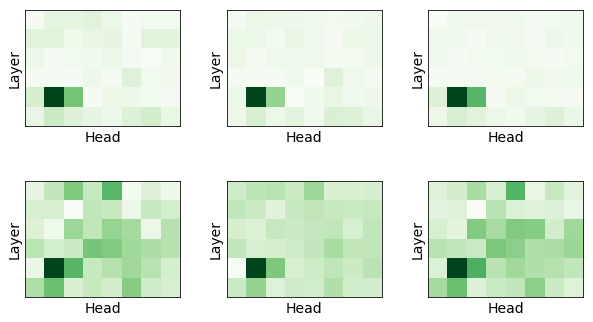

In [3]:
dataset_list=['rstdt-full','instructional','GUM']
dataset=dataset_list[2]
# figure=plt.figure(figsize=(13,5.5))
figure=plt.figure(figsize=(10,6))
# figure=plt.figure()
plt.subplots_adjust(wspace=1,hspace=0.1)
plt.subplots_adjust(wspace=0.3,hspace=0.1)
for idata,dataset in enumerate(dataset_list):
    f = '/scratch/wenxiao/summ_guided_dp_result/random_init/%s-cnndm-6-8-3-dep_perhead_cle_full.pt'%(dataset)
    all_trees= torch.load(f)
    ids = all_trees['0-0-sent_cons-cle'].keys()
    dep_tree_gt_list = []
    all_gt = torch.load('/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset))
    for i in ids:
    #     if all_gt[i]==[]:
    #         continue
    #     ids.append(i)
    #     print(all_gt[i])
        dep_tree_gt=all_gt[i]['dep_tree']
        dep_tree_gt_list.append(dep_tree_gt)
    
    ax=plt.subplot(2, 3, idata+1)
    acc_matrix = np.zeros((6,8))
    for l in range(6):
        for h in range(8):
            dep_tree_cand_list=[]
            for i in ids:
                dep_tree_cand_list.append(all_trees['%d-%d-nocons-cle'%(l,h)][i])
            acc = evaluate_dep_tree_list(dep_tree_gt_list,dep_tree_cand_list)[0]
            acc_matrix[l,h]=acc
    print('max: %f, min: %f, avg:%f'%(acc_matrix.max(),acc_matrix.min(),acc_matrix.mean()))
    im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower')
#     plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Head',fontsize=14)
    plt.ylabel('Layer',fontsize=14) 


    ax=plt.subplot(2, 3, idata+4)        
    acc_matrix = np.zeros((6,8))
    for l in range(6):
        for h in range(8):
            dep_tree_cand_list=[]
            for i in ids:
                dep_tree_cand_list.append(all_trees['%d-%d-sent_cons-cle'%(l,h)][i])
            acc = evaluate_dep_tree_list(dep_tree_gt_list,dep_tree_cand_list)[0]
            acc_matrix[l,h]=acc
    im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower')
#     plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Head',fontsize=14)
    plt.ylabel('Layer',fontsize=14) 
    print('max: %f, min: %f, avg:%f'%(acc_matrix.max(),acc_matrix.min(),acc_matrix.mean()))
    


max: 16.894038, min: 0.635395, avg:3.473844
max: 26.368903, min: 14.637451, avg:20.282716
max: 22.552886, min: 1.272858, avg:4.402340
max: 28.217999, min: 15.346002, avg:18.619278
max: 14.647028, min: 0.238042, avg:2.074810
max: 23.625679, min: 13.769248, avg:17.854398
max: 29.209494, min: 0.616707, avg:3.459731
max: 35.927864, min: 11.824893, avg:20.268310
max: 35.424883, min: 1.487989, avg:4.567796
max: 41.430620, min: 9.394048, avg:18.880348
max: 23.335565, min: 0.141337, avg:2.252101
max: 31.406680, min: 11.173101, avg:18.118631
max: 28.854420, min: 0.672771, avg:3.133371
max: 35.213044, min: 12.264063, avg:18.892302
max: 34.725708, min: 1.147365, avg:3.851440
max: 41.179634, min: 12.047329, avg:17.719912
max: 23.871160, min: 0.290114, avg:1.940756
max: 31.748866, min: 11.254928, avg:17.046511
max: 28.508690, min: 0.541955, avg:3.541686
max: 35.390581, min: 12.852738, avg:19.182065
max: 34.528505, min: 1.308713, avg:4.372087
max: 41.627824, min: 10.200789, avg:18.312268
max: 23.536

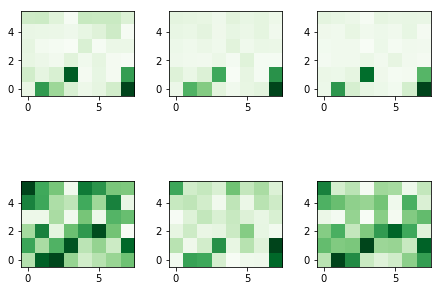

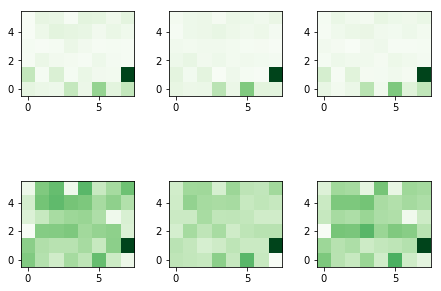

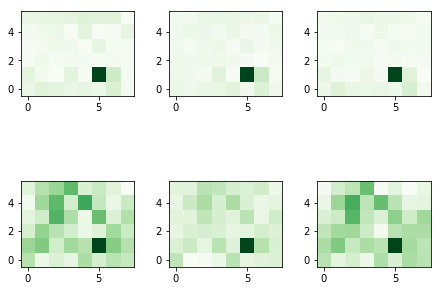

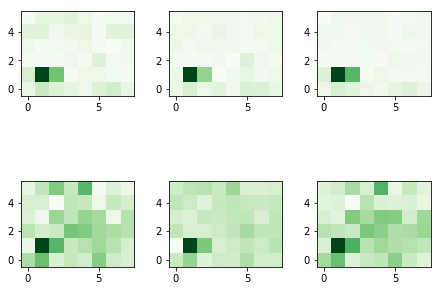

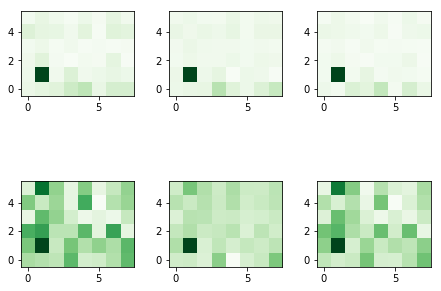

In [7]:
rstdt_nocons=[]
instruction_nocons=[]
gum_nocons=[]

rstdt_sentcons=[]
instruction_sentcons=[]
gum_sentcons=[]

for i_run in range(5):
    dataset_list=['rstdt-full','instructional','GUM']
    dataset=dataset_list[2]
    # figure=plt.figure(figsize=(13,5.5))
    figure=plt.figure(figsize=(10,6))
    # figure=plt.figure()
    plt.subplots_adjust(wspace=1,hspace=0.1)
    plt.subplots_adjust(wspace=0.3,hspace=0.1)
    for idata,dataset in enumerate(dataset_list):
        f = '/scratch/wenxiao/summ_guided_dp_result/random_init/%s-cnndm-6-8-%d-dep_perhead_cle_full.pt'%(dataset,i_run)
        all_trees= torch.load(f)
        ids = all_trees['0-0-sent_cons-cle'].keys()
        dep_tree_gt_list = []
        all_gt = torch.load('/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset))
        for i in ids:
        #     if all_gt[i]==[]:
        #         continue
        #     ids.append(i)
        #     print(all_gt[i])
            dep_tree_gt=all_gt[i]['dep_tree']
            dep_tree_gt_list.append(dep_tree_gt)

        ax=plt.subplot(2, 4, idata+1)
        acc_matrix = np.zeros((6,8))
        for l in range(6):
            for h in range(8):
                dep_tree_cand_list=[]
                for i in ids:
                    dep_tree_cand_list.append(all_trees['%d-%d-nocons-cle'%(l,h)][i])
                acc = evaluate_dep_tree_list(dep_tree_gt_list,dep_tree_cand_list,silent=True)[0]
                acc_matrix[l,h]=acc
        if dataset=='rstdt-full':
            rstdt_nocons.append(acc_matrix)
        elif dataset=='instructional':
            instruction_nocons.append(acc_matrix)
        else:
            gum_nocons.append(acc_matrix)
        print('max: %f, min: %f, avg:%f'%(acc_matrix.max(),acc_matrix.min(),acc_matrix.mean()))
        im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower')
    #     plt.colorbar()
        plt.xticks([])
        plt.yticks([])
    #     plt.xlabel('Head',fontsize=14)
    #     plt.ylabel('Layer',fontsize=14) 


        ax=plt.subplot(2, 4, idata+5)        
        acc_matrix = np.zeros((6,8))
        for l in range(6):
            for h in range(8):
                dep_tree_cand_list=[]
                for i in ids:
                    dep_tree_cand_list.append(all_trees['%d-%d-sent_cons-cle'%(l,h)][i])
                acc = evaluate_dep_tree_list(dep_tree_gt_list,dep_tree_cand_list,silent=True)[0]
                acc_matrix[l,h]=acc
        if dataset=='rstdt-full':
            rstdt_sentcons.append(acc_matrix)
        elif dataset=='instructional':
            instruction_sentcons.append(acc_matrix)
        else:
            gum_sentcons.append(acc_matrix)
        im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower')
    #     plt.colorbar()
        plt.xticks([])
        plt.yticks([])
    #     plt.xlabel('Head',fontsize=14)
    #     plt.ylabel('Layer',fontsize=14) 
        print('max: %f, min: %f, avg:%f'%(acc_matrix.max(),acc_matrix.min(),acc_matrix.mean()))
    

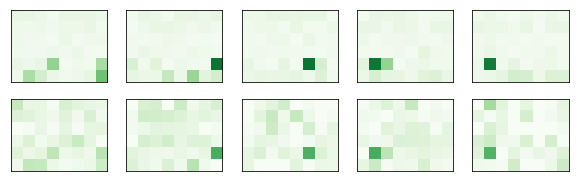

In [8]:
figure=plt.figure(figsize=(10,3))
for i in range(len(rstdt_sentcons)):
    ax=plt.subplot(2, 5, i+1) 
    acc_matrix = (rstdt_nocons[i]+instruction_nocons[i]+gum_nocons[i])/3
    im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower',vmin=0, vmax=35)
    plt.xticks([])
    plt.yticks([])
#     plt.xlabel('Head',fontsize=14)
#     plt.ylabel('Layer',fontsize=14) 
    
    ax=plt.subplot(2, 5, i+6) 
    acc_matrix = (rstdt_sentcons[i]+instruction_sentcons[i]+gum_sentcons[i])/3
    im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower',vmin=15, vmax=50)
    plt.xticks([])
    plt.yticks([])
#     plt.xlabel('Head',fontsize=14)
#     plt.ylabel('Layer',fontsize=14) 
 

max: 3.275089, min: 0.901701, avg:1.769042
max: 22.103345, min: 15.585872, avg:18.425781
max: 4.266762, min: 1.738975, avg:3.053663
max: 19.881678, min: 15.614916, avg:17.731116
max: 1.859704, min: 0.438890, avg:0.909085
max: 19.169828, min: 13.888269, avg:16.604367
max: 5.256027, min: 0.331714, avg:1.736144
max: 26.210054, min: 11.021304, avg:18.482040
max: 7.995697, min: 1.523844, avg:2.970001
max: 21.764073, min: 12.979563, avg:17.579479
max: 2.291155, min: 0.312430, avg:0.925513
max: 22.063527, min: 11.552481, avg:16.481936
max: 19.015137, min: 0.415810, avg:2.633269
max: 30.569053, min: 10.054195, avg:19.518451
max: 23.915382, min: 1.774830, avg:3.950415
max: 32.054500, min: 13.033345, avg:18.123282
max: 18.039128, min: 0.238042, avg:1.783611
max: 26.757420, min: 10.935059, avg:17.943508
max: 22.794805, min: 0.397122, avg:3.003430
max: 30.910110, min: 10.451318, avg:18.987008
max: 27.447114, min: 1.452133, avg:4.025861
max: 35.389028, min: 13.624955, avg:17.819634
max: 18.425947, 

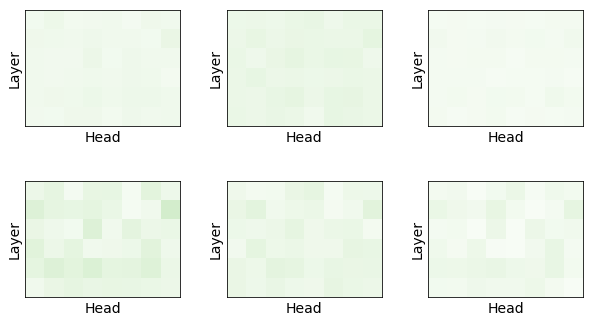

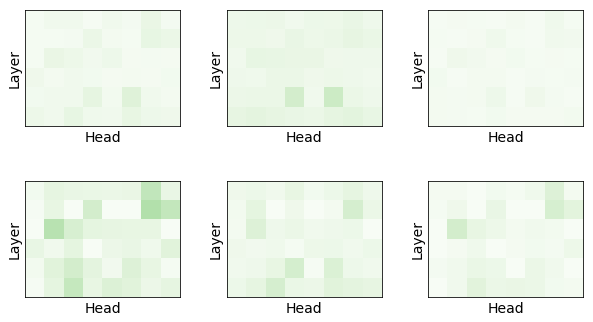

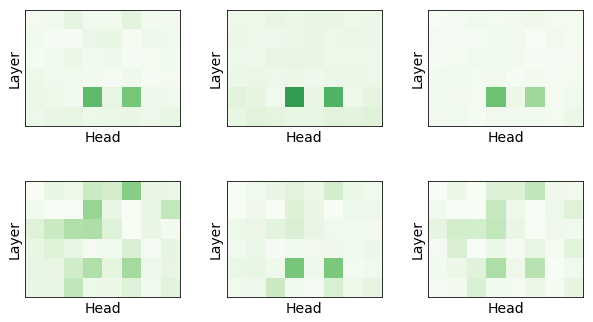

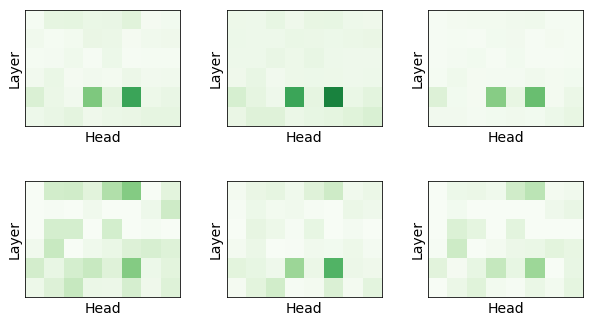

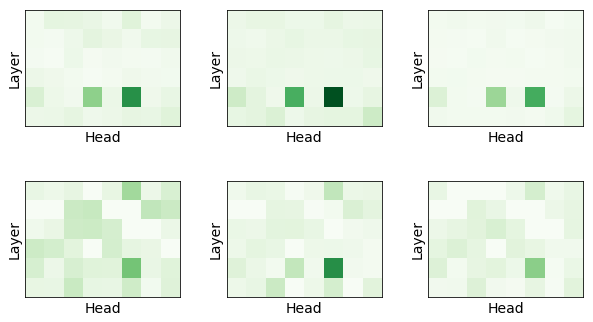

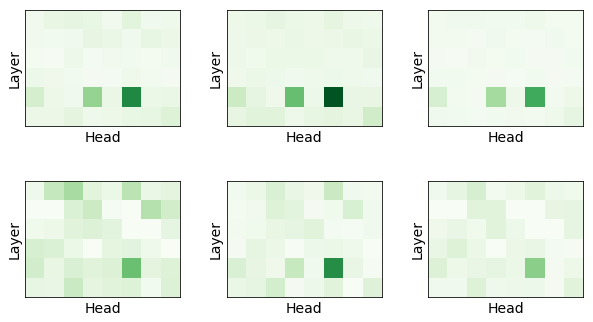

In [4]:
rstdt_nocons=[]
instruction_nocons=[]
gum_nocons=[]

rstdt_sentcons=[]
instruction_sentcons=[]
gum_sentcons=[]

for runtime in [0,1,5,10,20,23]:
    dataset_list=['rstdt-full','instructional','GUM']
    dataset=dataset_list[2]
    # figure=plt.figure(figsize=(13,5.5))
    figure=plt.figure(figsize=(10,6))
    # figure=plt.figure()
    plt.subplots_adjust(wspace=1,hspace=0.1)
    plt.subplots_adjust(wspace=0.3,hspace=0.1)
    for idata,dataset in enumerate(dataset_list):
        f = '/scratch/wenxiao/summ_guided_dp_result/error_pg/%s-cnndm-6-8-%d-dep_perhead_cle.pt'%(dataset,runtime)
        all_trees= torch.load(f)
        ids = all_trees['0-0-sent_cons-cle'].keys()
        dep_tree_gt_list = []
        all_gt = torch.load('/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset))
        for i in ids:
        #     if all_gt[i]==[]:
        #         continue
        #     ids.append(i)
        #     print(all_gt[i])
            dep_tree_gt=all_gt[i]['dep_tree']
            dep_tree_gt_list.append(dep_tree_gt)
        
        
        ax=plt.subplot(2, 3, idata+1)
        acc_matrix = np.zeros((6,8))
        for l in range(6):
            for h in range(8):
                dep_tree_cand_list=[]
                for i in ids:
                    dep_tree_cand_list.append(all_trees['%d-%d-nocons-cle'%(l,h)][i])
                acc = evaluate_dep_tree_list(dep_tree_gt_list,dep_tree_cand_list,silent=True)[0]
                acc_matrix[l,h]=acc
        print('max: %f, min: %f, avg:%f'%(acc_matrix.max(),acc_matrix.min(),acc_matrix.mean()))
        if dataset=='rstdt-full':
            rstdt_nocons.append(acc_matrix)
        elif dataset=='instructional':
            instruction_nocons.append(acc_matrix)
        else:
            gum_nocons.append(acc_matrix)
        im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower',vmin=0, vmax=35)
    #     plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Head',fontsize=14)
        plt.ylabel('Layer',fontsize=14) 


        ax=plt.subplot(2, 3, idata+4)        
        acc_matrix = np.zeros((6,8))
        for l in range(6):
            for h in range(8):
                dep_tree_cand_list=[]
                for i in ids:
                    dep_tree_cand_list.append(all_trees['%d-%d-sent_cons-cle'%(l,h)][i])
                acc = evaluate_dep_tree_list(dep_tree_gt_list,dep_tree_cand_list,silent=True)[0]
                acc_matrix[l,h]=acc
        if dataset=='rstdt-full':
            rstdt_sentcons.append(acc_matrix)
        elif dataset=='instructional':
            instruction_sentcons.append(acc_matrix)
        else:
            gum_sentcons.append(acc_matrix)
        im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower',vmin=15, vmax=50)
    #     plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Head',fontsize=14)
        plt.ylabel('Layer',fontsize=14) 
        print('max: %f, min: %f, avg:%f'%(acc_matrix.max(),acc_matrix.min(),acc_matrix.mean()))


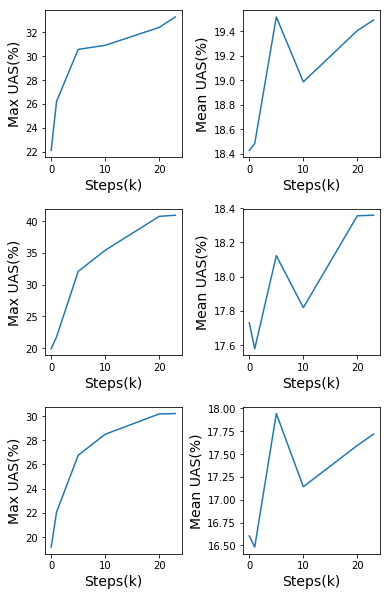

Text(0, 0.5, 'Mean UAS(%)')

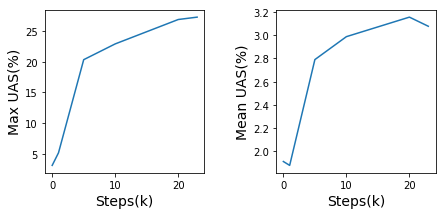

In [31]:
# figure=plt.figure()
figure=plt.figure(figsize=(6,10))
# plt.subplots_adjust(wspace=1,hspace=0.1)
plt.subplots_adjust(wspace=0.45,hspace=0.35)
x = [0,1,5,10,20,23]
y = [acc_matrix.max() for acc_matrix in rstdt_sentcons]
plt.subplot(3,2,1)
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Max UAS(%)',fontsize=14)
    
y = [acc_matrix.max() for acc_matrix in instruction_sentcons]
plt.subplot(3,2,3)
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Max UAS(%)',fontsize=14)
y = [acc_matrix.max() for acc_matrix in gum_sentcons]
plt.subplot(3,2,5)
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Max UAS(%)',fontsize=14)

y = [acc_matrix.mean() for acc_matrix in rstdt_sentcons]
plt.subplot(3,2,2)
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Mean UAS(%)',fontsize=14)
y = [acc_matrix.mean() for acc_matrix in instruction_sentcons]
plt.subplot(3,2,4)
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Mean UAS(%)',fontsize=14)
y = [acc_matrix.mean() for acc_matrix in gum_sentcons]
plt.subplot(3,2,6)
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Mean UAS(%)',fontsize=14)
plt.show()


figure=plt.figure(figsize=(7,3))
plt.subplots_adjust(wspace=0.45)
plt.subplot(1,2,1)
y = [(rstdt_nocons[i].max()+instruction_nocons[i].max()+gum_nocons[i].max())/3 for i in range(len(rstdt_sentcons))]
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Max UAS(%)',fontsize=14)
plt.subplot(1,2,2)
y = [(rstdt_nocons[i].mean()+instruction_nocons[i].mean()+gum_nocons[i].mean())/3 for i in range(len(rstdt_sentcons))]
plt.plot(x,y)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('Mean UAS(%)',fontsize=14)

Text(0, 0.5, 'ROUGE-L')

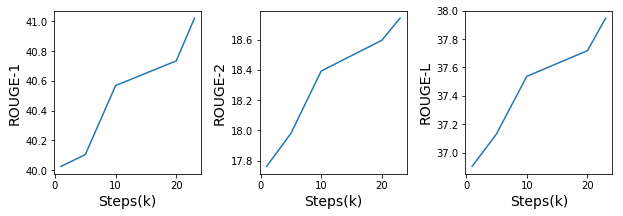

In [5]:
x = [1,5,10,20,23]
r1=[28.2430,40.0250,40.1040,40.5680,40.7340,41.0210]
# r2=[8.5160,17.7630,17.9800,18.3920,18.5950,18.7410]
# rl=[25.69,36.9030,37.1310,37.5370,37.7180,37.9470]
r1=[40.0250,40.1040,40.5680,40.7340,41.0210]
r2=[17.7630,17.9800,18.3920,18.5950,18.7410]
rl=[36.9030,37.1310,37.5370,37.7180,37.9470]
figure=plt.figure(figsize=(10,3))
# plt.subplots_adjust(wspace=1,hspace=0.1)
plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.subplot(1,3,1)
plt.plot(x,r1)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('ROUGE-1',fontsize=14)

plt.subplot(1,3,2)
plt.plot(x,r2)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('ROUGE-2',fontsize=14)

plt.subplot(1,3,3)
plt.plot(x,rl)
plt.xlabel('Steps(k)',fontsize=14)
plt.ylabel('ROUGE-L',fontsize=14)

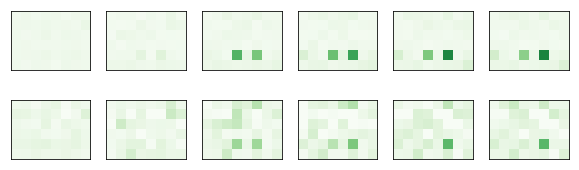

In [24]:
figure=plt.figure(figsize=(10,3))
for i in range(len(rstdt_sentcons)):
    ax=plt.subplot(2, 6, i+1) 
    acc_matrix = (rstdt_nocons[i]+instruction_nocons[i]+gum_nocons[i])/3
    im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower',vmin=0, vmax=35)
    plt.xticks([])
    plt.yticks([])
#     plt.xlabel('Head',fontsize=14)
#     plt.ylabel('Layer',fontsize=14) 
    
    ax=plt.subplot(2, 6, i+7) 
    acc_matrix = (rstdt_sentcons[i]+instruction_sentcons[i]+gum_sentcons[i])/3
    im = plt.imshow(acc_matrix,cmap=plt.get_cmap('Greens'),origin='lower',vmin=15, vmax=50)
    plt.xticks([])
    plt.yticks([])
#     plt.xlabel('Head',fontsize=14)
#     plt.ylabel('Layer',fontsize=14) 
    

In [14]:
data_list=['./em_dataset/all/', './instruction_dataset/all','./GUM_binary/']
all_data = torch.load('./GUM_binary/all.pt')
num_edus_total = 0
num_sentences_total = 0
length_doc_total = 0
num_data = len(all_data)
for d in all_data:
    num_edus_total+=len(d['disco_txt'])
    num_sentences_total +=len(d['sentence_boundary'])
    length_doc_total+=sum([len(d['disco_txt'][i]) for i in range(len(d['disco_txt']))])
avg_num_edus = num_edus_total/num_data
avg_num_sent = num_sentences_total/num_data
avg_length_edus = length_doc_total/num_edus_total
avg_length_sent=length_doc_total/num_sentences_total
avg_length_doc=length_doc_total/num_data
print('number of documents: %d'%(num_data))
print('avg number of edus: %f\n avg number of sentences: %f\n avgnumber of words each edu: %f\n avg number of words per sentence: %f\n avg number of words per doc:%f '%(avg_num_edus,avg_num_sent,avg_length_edus,avg_length_sent,avg_length_doc))

number of documents: 127
avg number of edus: 106.850394
 avg number of sentences: 45.031496
 avgnumber of words each edu: 8.178998
 avg number of words per sentence: 19.407064
 avg number of words per doc:873.929134 


In [2]:
def get_tree_property(deptree):
    resultdict={}
    all_node_out = set(deptree.keys())
    all_node_in = set([n for v in deptree.values() for n in v])
#     print(all_node_in)
    root = all_node_out.difference(all_node_in).pop()
    leaf = all_node_in.difference(all_node_out)
    
#     print(all_node_out.difference(all_node_in))
    resultdict['branch_max']  = max([len(v) for v in deptree.values()])
    resultdict['branch_min']  = min([len(v) for v in deptree.values()])
    resultdict['branch_avg'] = sum([len(v) for v in deptree.values()])/len(deptree.values())
    resultdict['branch_median']= np.median([len(v) for v in deptree.values()])
    resultdict['depth'] = get_depth(deptree,root)
    resultdict['num_leaf']=len(leaf)
    resultdict['num_node'] = len(all_node_in)+1
    resultdict['normalized_arc_length']=(get_avg_arc_length(deptree)/len(all_node_in))
    resultdict['vacuous_tree']=check_vacuous_tree(deptree)
    return resultdict

def get_depth(deptree,start):
    if start not in deptree.keys():
        return 1
    return 1+max([get_depth(deptree,n) for n in deptree[start]])

def get_avg_arc_length(deptree):
    arc_length=0
    arc_num=0
    for k in deptree.keys():
        for v in deptree[k]:
            arc_length+=abs(v-k)
            arc_num+=1
    return arc_length/arc_num
    
def check_vacuous_tree(deptree):
    if len(deptree.keys())==1:
        return True
    return False

In [3]:
dataset_list=['rstdt-full','instructional','GUM']
for idata,dataset in enumerate(dataset_list):
    print('Dataset: %s'%(dataset))
    f = '/scratch/wenxiao/summ_guided_dp_result/%s-cnndm-6-8-dep_perhead_cle.pt'%(dataset)
    all_trees= torch.load(f)
    ids = all_trees['0-0-sent_cons-cle'].keys()
    dep_tree_gt_list = []
    all_gt = torch.load('/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset))
    for i in ids:
    #     if all_gt[i]==[]:
    #         continue
    #     ids.append(i)
    #     print(all_gt[i])
        dep_tree_gt=all_gt[i]['dep_tree']
        dep_tree_gt_list.append(dep_tree_gt)
        
    dep_tree_cand_list=[]
    for i in ids:
        dep_tree_cand = {k: list(all_trees['1-1-sent_cons-cle'][i][k].keys()) for k in all_trees['1-1-sent_cons-cle'][i].keys()}
        dep_tree_cand_list.append(dep_tree_cand)
        
    
    
    branch_max_total=0
    branch_min_total=0
    branch_avg_total=0
    branch_median_total=0
    depth_total=0
    leaf_num_total=0
    node_num_total=0
    leaf_ratio_total=0
    normalized_arc_length_total=0
    vacuous_tree_num=0
    for deptree in dep_tree_gt_list:
        resultdict= get_tree_property(deptree)
        branch_max_total+=resultdict['branch_max']
        branch_min_total+=resultdict['branch_min']
        branch_avg_total+=resultdict['branch_avg']
        branch_median_total+=resultdict['branch_median']
        depth_total+=resultdict['depth']
        leaf_num_total+=resultdict['num_leaf']
        node_num_total+=resultdict['num_node']
        leaf_ratio_total+=(resultdict['num_leaf']/resultdict['num_node'])
        normalized_arc_length_total+=resultdict['normalized_arc_length']
        if resultdict['vacuous_tree']:
            vacuous_tree_num+=1
            print(deptree)
    print('GT tree\n avg branch max: %f, avg branch min: %f, avg branch avg: %f, avg depth: %f, avg median: %f, \
    avg leaf ratio(micro): %f, avg leaf ratio(macro): %f, avg norm. arc. length: %f, vacuous tree ratio: %f'\
         %(branch_max_total/len(dep_tree_gt_list),branch_min_total/len(dep_tree_gt_list),\
           branch_avg_total/len(dep_tree_gt_list),depth_total/len(dep_tree_gt_list),\
           branch_median_total/len(dep_tree_gt_list),leaf_num_total/node_num_total,leaf_ratio_total/len(dep_tree_gt_list),\
          normalized_arc_length_total/len(dep_tree_gt_list),vacuous_tree_num/len(dep_tree_gt_list) ))
    
    branch_max_total=0
    branch_min_total=0
    branch_avg_total=0
    branch_median_total=0
    depth_total=0
    leaf_num_total=0
    node_num_total=0
    leaf_ratio_total=0
    normalized_arc_length_total=0
    vacuous_tree_num=0
    for deptree in dep_tree_cand_list:
        resultdict= get_tree_property(deptree)
        branch_max_total+=resultdict['branch_max']
        branch_min_total+=resultdict['branch_min']
        branch_avg_total+=resultdict['branch_avg']
        branch_median_total+=resultdict['branch_median']
        depth_total+=resultdict['depth']
        leaf_num_total+=resultdict['num_leaf']
        node_num_total+=resultdict['num_node']
        leaf_ratio_total+=(resultdict['num_leaf']/resultdict['num_node'])
        normalized_arc_length_total+=resultdict['normalized_arc_length']
        if resultdict['vacuous_tree']:
            vacuous_tree_num+=1
            print(deptree)
    print('Candidate tree\n avg branch max: %f, avg branch min: %f, avg branch avg: %f, avg depth: %f, avg median: %f, \
    avg leaf ratio(micro): %f, avg leaf ratio(macro): %f, avg norm. arc. length: %f, vacuous tree ratio: %f'\
         %(branch_max_total/len(dep_tree_gt_list),branch_min_total/len(dep_tree_gt_list),\
           branch_avg_total/len(dep_tree_gt_list),depth_total/len(dep_tree_gt_list),\
           branch_median_total/len(dep_tree_gt_list),leaf_num_total/node_num_total,leaf_ratio_total/len(dep_tree_gt_list),\
           normalized_arc_length_total/len(dep_tree_gt_list),vacuous_tree_num/len(dep_tree_gt_list)))
    

Dataset: rstdt-full
{1: [0, 2]}
{0: [1]}
{0: [1]}
{0: [1]}
{0: [1, 2, 3]}
{0: [1, 2]}
{1: [0, 2, 3, 4]}
GT tree
 avg branch max: 5.412987, avg branch min: 1.051948, avg branch avg: 2.100000, avg depth: 8.189610, avg median: 1.767532,     avg leaf ratio(micro): 0.515489, avg leaf ratio(macro): 0.535549, avg norm. arc. length: 0.130829, vacuous tree ratio: 0.018182
{1: [2, 0]}
{1: [0]}
{1: [0]}
{1: [0]}
{2: [1, 3, 0]}
{2: [0, 1]}
{2: [0, 1]}
{2: [1, 0]}
{2: [1, 3, 0]}
{2: [0, 3, 1]}
Candidate tree
 avg branch max: 5.511688, avg branch min: 1.025974, avg branch avg: 1.499450, avg depth: 27.064935, avg median: 1.111688,     avg leaf ratio(micro): 0.366378, avg leaf ratio(macro): 0.352447, avg norm. arc. length: 0.098739, vacuous tree ratio: 0.025974
Dataset: instructional
{0: [1]}
GT tree
 avg branch max: 3.835227, avg branch min: 1.000000, avg branch avg: 1.586123, avg depth: 8.494318, avg median: 1.238636,     avg leaf ratio(micro): 0.409802, avg leaf ratio(macro): 0.405430, avg norm. ar

In [6]:
dataset_list=['rstdt-full','instructional','GUM']
for idata,dataset in enumerate(dataset_list):
    print('Dataset: %s'%(dataset))
    f = '/scratch/wenxiao/summ_guided_dp_result/%s-cnndm-6-8-dep_perhead_cle.pt'%(dataset)
    all_trees= torch.load(f)
    ids = all_trees['0-0-sent_cons-cle'].keys()
    dep_tree_gt_list = []
    all_gt = torch.load('/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset))
    for i in ids:
    #     if all_gt[i]==[]:
    #         continue
    #     ids.append(i)
    #     print(all_gt[i])
        dep_tree_gt=all_gt[i]['dep_tree']
        dep_tree_gt_list.append(dep_tree_gt)
        
    dep_tree_cand_list=[]
    for i in ids:
        dep_tree_cand = {k: list(all_trees['1-1-nocons-cle'][i][k].keys()) for k in all_trees['1-1-nocons-cle'][i].keys()}
        dep_tree_cand_list.append(dep_tree_cand)
        
    
    
    branch_max_total=[]
    branch_min_total=[]
    branch_avg_total=[]
    branch_median_total=[]
    depth_total=[]
    for deptree in dep_tree_gt_list:
        branch_max,branch_min,branch_avg,depth, branch_median= get_depth_branch_tree(deptree)
        branch_max_total.append(branch_max)
        branch_min_total.append(branch_min)
        branch_avg_total.append(branch_avg)
        branch_median_total.append(branch_median)
        depth_total.append(depth)
        
    print('GT tree\n med branch max: %f, med branch min: %f, med branch avg: %f, med depth: %f, med median: %f'\
         %(np.median(branch_max_total),np.median(branch_min_total),\
           np.median(branch_avg_total),np.median(depth_total),np.median(branch_median_total)))
    
    branch_max_total=[]
    branch_min_total=[]
    branch_avg_total=[]
    branch_median_total=[]
    depth_total=[]
    for deptree in dep_tree_cand_list:
        branch_max,branch_min,branch_avg,depth, branch_median= get_depth_branch_tree(deptree)
        branch_max_total.append(branch_max)
        branch_min_total.append(branch_min)
        branch_avg_total.append(branch_avg)
        branch_median_total.append(branch_median)
        depth_total.append(depth)
    print('Cand tree\n med branch max: %f, med branch min: %f, med branch avg: %f, med depth: %f, med median: %f'\
         %(np.median(branch_max_total),np.median(branch_min_total),\
           np.median(branch_avg_total),np.median(depth_total),np.median(branch_median_total)))
    

Dataset: rstdt-full
GT tree
 med branch max: 5.000000, med branch min: 1.000000, med branch avg: 2.062500, med depth: 7.000000, med median: 2.000000
Cand tree
 med branch max: 3.000000, med branch min: 1.000000, med branch avg: 1.548387, med depth: 23.000000, med median: 1.000000
Dataset: instructional
GT tree
 med branch max: 3.000000, med branch min: 1.000000, med branch avg: 1.597297, med depth: 8.000000, med median: 1.000000
Cand tree
 med branch max: 3.000000, med branch min: 1.000000, med branch avg: 1.666667, med depth: 10.000000, med median: 1.500000
Dataset: GUM
GT tree
 med branch max: 7.000000, med branch min: 1.000000, med branch avg: 2.014706, med depth: 11.000000, med median: 2.000000
Cand tree
 med branch max: 15.000000, med branch min: 1.000000, med branch avg: 2.057692, med depth: 46.000000, med median: 1.000000


In [30]:
def local_distant_accuracy(dep_tree_gt,dep_tree_cand):
    total=0
    correct_local=0
    correct_distant=0
    local_gt=0
    local_cand=0
    for key in dep_tree_gt.keys():
        if key in dep_tree_cand.keys():
            correct_keys=set(dep_tree_gt[key]).intersection(set(dep_tree_cand[key]))
            correct_all=len(correct_keys)
            if key-1 in correct_keys:
                correct_local+=1
                correct_all-=1
            if key+1 in correct_keys:
                correct_local+=1
                correct_all-=1              
            correct_distant+=correct_all
        total+=len(dep_tree_gt[key])
        
    for key in dep_tree_gt.keys():
        if key-1 in dep_tree_gt[key]:
            local_gt+=1
        if key+1 in dep_tree_gt[key]:
            local_gt+=1
            
    for key in dep_tree_cand.keys():
        if key-1 in dep_tree_cand[key]:
            local_cand+=1
        if key+1 in dep_tree_cand[key]:
            local_cand+=1
    
    return correct_local,correct_distant,total,local_gt,local_cand


def local_distant_accuracy_list(dep_tree_gt_list,dep_tree_cand_list):
    correct_all=0
    correct_local_all=0
    correct_distant_all=0
    total_all=0
    total_macro=0
    local_gt_all=0
    local_cand_all=0
    for i in range(len(dep_tree_gt_list)):
        correct_local,correct_distant,total,local_gt,local_cand=local_distant_accuracy(dep_tree_gt_list[i],dep_tree_cand_list[i])
        correct_local_all+=correct_local
        correct_distant_all+=correct_distant
        total_all+=total
        total_macro+=((correct_local+correct_distant)/total)
        local_gt_all+=local_gt
        local_cand_all+=local_cand
    correct_all = correct_local_all+correct_distant_all
    micro_f1 = correct_all/total_all
    correct_local_ratio = correct_local_all/correct_all
    correct_distant_ratio = correct_distant_all/correct_all
    macro_f1 = total_macro/len(dep_tree_gt_list)
    local_correct_recall=correct_local_all/local_cand_all
    local_correct_precision = correct_local_all/local_gt_all
    print('correct num: ',correct_all)
    print('total_num: ',total_all)
    print('micro f1: ',micro_f1)
    print('macro f1: ', macro_f1)
    print('local ratio: ', correct_local_ratio)
    print('distant ratio: ', correct_distant_ratio)
    print('local correct recall: ', local_correct_recall)
    print('local correct precision: ', local_correct_precision)
    print('local ratio in gt: ',local_gt_all/total_all)
    print('local ratio in cand: ',local_cand_all/total_all)
    return micro_f1,macro_f1



def local_minus_plus_distant_accuracy(dep_tree_gt,dep_tree_cand):
    total=0
    correct_local_minus=0
    correct_local_plus=0
    correct_distant=0
    for key in dep_tree_gt.keys():
        if key in dep_tree_cand.keys():
            correct_keys=set(dep_tree_gt[key]).intersection(set(dep_tree_cand[key]))
            correct_all=len(correct_keys)
            if key-1 in correct_keys:
                correct_local_minus+=1
                correct_all-=1
            if key+1 in correct_keys:
                correct_local_plus+=1
                correct_all-=1
            correct_distant+=correct_all
        total+=len(dep_tree_gt[key])
    return correct_local_minus,correct_local_plus,correct_distant,total



def local_minus_plus_distant_accuracy_list(dep_tree_gt_list,dep_tree_cand_list):
    correct_all=0
    correct_local_minus_all=0
    correct_local_plus_all=0
    correct_distant_all=0
    total_all=0
    total_macro=0
    for i in range(len(dep_tree_gt_list)):
        correct_local_minus,correct_local_plus,correct_distant,total=local_minus_plus_distant_accuracy(dep_tree_gt_list[i],dep_tree_cand_list[i])
        correct_local_minus_all+=correct_local_minus
        correct_local_plus_all+=correct_local_plus
        correct_distant_all+=correct_distant
        total_all+=total
        total_macro+=((correct_local_minus+correct_local_plus+correct_distant)/total)
    correct_all = correct_local_minus_all+correct_local_plus_all+correct_distant_all
    micro_f1 = correct_all/total_all
    correct_local_minus_ratio = correct_local_minus_all/correct_all
    correct_local_plus_ratio = correct_local_plus_all/correct_all
    correct_distant_ratio = correct_distant_all/correct_all
    macro_f1 = total_macro/len(dep_tree_gt_list)
    print('correct num: ',correct_all)
    print('total_num: ',total_all)
    print('micro f1: ',micro_f1)
    print('macro f1: ', macro_f1)
    print('local minus ratio: ', correct_local_minus_ratio)
    print('local plus ratio: ', correct_local_plus_ratio)
    print('distant ratio: ', correct_distant_ratio)

    return micro_f1,macro_f1



In [33]:
dataset_list=['rstdt-full','instructional','GUM']
for idata,dataset in enumerate(dataset_list):
    print('Dataset: %s'%(dataset))
    f = '/scratch/wenxiao/summ_guided_dp_result/%s-cnndm-6-8-dep_perhead_cle.pt'%(dataset)
    all_trees= torch.load(f)
    ids = all_trees['0-0-sent_cons-cle'].keys()
    dep_tree_gt_list = []
    all_gt = torch.load('/scratch/wenxiao/summ_guided_dp_gt/%s-gt.pt'%(dataset))
    for i in ids:
    #     if all_gt[i]==[]:
    #         continue
    #     ids.append(i)
    #     print(all_gt[i])
        dep_tree_gt=all_gt[i]['dep_tree']
        dep_tree_gt_list.append(dep_tree_gt)
        
    dep_tree_cand_list=[]
    for i in ids:
        dep_tree_cand = {k: list(all_trees['1-1-nocons-cle'][i][k].keys()) for k in all_trees['1-1-nocons-cle'][i].keys()}
        dep_tree_cand_list.append(dep_tree_cand)
    local_distant_accuracy_list(dep_tree_gt_list,dep_tree_cand_list)

Dataset: rstdt-full
correct num:  5900
total_num:  21404
micro f1:  0.275649411324986
macro f1:  0.3210666193485579
local ratio:  0.7777966101694915
distant ratio:  0.22220338983050847
local correct recall:  0.46088179170432864
local correct precision:  0.40286190852427356
local ratio in gt:  0.5321902448140534
local ratio in cand:  0.4651934217903196
Dataset: instructional
correct num:  1926
total_num:  5578
micro f1:  0.345285048404446
macro f1:  0.4030802730747217
local ratio:  0.8115264797507789
distant ratio:  0.18847352024922118
local correct recall:  0.5849550898203593
local correct precision:  0.4683847767455799
local ratio in gt:  0.5982430978845464
local ratio in cand:  0.4790247400501972
Dataset: GUM
correct num:  3094
total_num:  13443
micro f1:  0.23015695901212527
macro f1:  0.25376496333021525
local ratio:  0.7798965740142211
distant ratio:  0.22010342598577892
local correct recall:  0.44909733854457473
local correct precision:  0.33687002652519893
local ratio in gt:  0.